<a href="https://colab.research.google.com/github/chanakyaitgithub/stock/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
def display(na):
  import os
  import pandas as pd
  import numpy as np
  import math
  import datetime as dt

  from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
  from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
  from sklearn.preprocessing import MinMaxScaler


  import tensorflow as tf
  from tensorflow.python.keras.models import Sequential
  from tensorflow.python.keras.layers import Dense, Dropout
  from tensorflow.python.keras.layers import LSTM
  import matplotlib.pyplot as plt
  from itertools import cycle
  import plotly.graph_objects as go
  import plotly.express as px
  from plotly.subplots import make_subplots



  path= na
  datapd=pd.read_csv(path)

  print('Total number of days present in the dataset: ',datapd.shape[0])
  print('Total number of fields present in the dataset: ',datapd.shape[1])

  datapd.head()
  datapd.tail()
  datapd.info()
  datapd.describe()

  print('Null Values:',datapd.isnull().values.sum())

  print('NA values:',datapd.isnull().values.any())

  datapd=datapd.dropna()
  print('Null Values:',datapd.isnull().values.sum())
  print('NA values:',datapd.isnull().values.any())

  datapd.shape

  datapd.tail()
  sd=datapd.iloc[0][0]
  ed=datapd.iloc[-1][0]


  print('Starting Date',sd)
  print('Ending Date',ed)
  std=sd

  datapd['Date'] = pd.to_datetime(datapd['Date'], format='%Y-%m-%d')

  y_overall = datapd.loc[(datapd['Date'] >= "'"+sd+"'")
                     & (datapd['Date'] <= '2023-10-23')]

  y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

  monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
  new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
  monthvise = monthvise.reindex(new_order, axis=0)
  print(monthvise)

  closedf = datapd[['Date','Close']]
  print("Shape of close dataframe:", closedf.shape)

  fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
  fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='red')
  fig.update_layout(title_text='timeframe', plot_bgcolor='white',
                  font_size=15, font_color='blue')
  fig.update_xaxes(showgrid=False)
  fig.update_yaxes(showgrid=False)
  fig.show()

  closedf = closedf[closedf['Date'] > '2021-10-10']
  close_stock = closedf.copy()
  print("Total data for prediction: ",closedf.shape[0])

  fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
  fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
  fig.update_layout(title_text='Considered period for the stock',
                  plot_bgcolor='white', font_size=15, font_color='black')
  fig.update_xaxes(showgrid=False)
  fig.update_yaxes(showgrid=False)
  fig.show()

  del closedf['Date']
  scaler=MinMaxScaler(feature_range=(0,1))
  closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
  print(closedf.shape)

  training_size=int(len(closedf)*0.60)
  test_size=len(closedf)-training_size
  train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
  print("train_data: ", train_data.shape)
  print("test_data: ", test_data.shape)

  def create_dataset(dataset, time_step=1):
      dataX, dataY = [], []
      for i in range(len(dataset)-time_step-1):
          a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
          dataX.append(a)
          dataY.append(dataset[i + time_step, 0])
      return np.array(dataX), np.array(dataY)

  time_step = 15
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  print("X_train: ", X_train.shape)
  print("y_train: ", y_train.shape)
  print("X_test: ", X_test.shape)
  print("y_test", y_test.shape)

  X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

  print("X_train: ", X_train.shape)
  print("X_test: ", X_test.shape)

  model=Sequential()

  model.add(LSTM(10,input_shape=(None,1),activation="relu"))

  model.add(Dense(1))

  model.compile(loss="mean_squared_error",optimizer="adam")

  history= model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)


  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)
  train_predict.shape, test_predict.shape

  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
  original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

  print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
  print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
  print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
  print("-------------------------------------------------------------------------------------")
  print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
  print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
  print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))


  look_back=time_step
  trainPredictPlot = np.empty_like(closedf)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  print("Train predicted data: ", trainPredictPlot.shape)

  testPredictPlot = np.empty_like(closedf)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
  print("Test predicted data: ", testPredictPlot.shape)

  names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


  plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

  fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],labels={'value':'Stock price','date': 'Date'})
  fig.update_layout(title_text='Comparision between original close price vs predicted close price',plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
  fig.for_each_trace(lambda t:  t.update(name = next(names)))

  fig.update_xaxes(showgrid=False)
  fig.update_yaxes(showgrid=False)
  fig.show()

  x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  from numpy import array

  lst_output=[]
  n_steps=time_step
  i=0
  pred_days = 7
  while(i<pred_days):

      if(len(temp_input)>time_step):

          x_input=np.array(temp_input[1:])
          x_input = x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))

          yhat = model.predict(x_input, verbose=0)
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]

          lst_output.extend(yhat.tolist())
          i=i+1

      else:

          x_input = x_input.reshape((1, n_steps,1))
          yhat = model.predict(x_input, verbose=0)
          temp_input.extend(yhat[0].tolist())

          lst_output.extend(yhat.tolist())
          i=i+1

  print("Output of predicted next days: ", len(lst_output))

  last_days=np.arange(1,time_step+1)
  day_pred=np.arange(time_step+1,time_step+pred_days+1)
  print(last_days)
  print(day_pred)

  temp_mat = np.empty((len(last_days)+pred_days+1,1))
  temp_mat[:] = np.nan
  temp_mat = temp_mat.reshape(1,-1).tolist()[0]

  last_original_days_value = temp_mat
  next_predicted_days_value = temp_mat

  last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
  next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
  print(next_predicted_days_value)
  hello=pd.DataFrame({"dates":['24-10-23','25-10-23','26-10-23','27-10-23','28-10-23','29-10-23','30-10-23'],"predicted_values":(next_predicted_days_value[16:23])})
  print(hello)

  new_pred_plot = pd.DataFrame({
      'last_original_days_value':last_original_days_value,
      'next_predicted_days_value':next_predicted_days_value
    })


  names = cycle(['Last 15 days close price','Predicted next 7 days close price'])

  fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],new_pred_plot['next_predicted_days_value']],labels={'value': 'Stock price','index': 'Timestamp'})
  fig.update_layout(title_text='Compare last 15 days vs next 7 days',plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

  fig.for_each_trace(lambda t:  t.update(name = next(names)))
  fig.update_xaxes(showgrid=False)
  fig.update_yaxes(showgrid=False)
  fig.show()

  start_date = pd.Timestamp('2023-10-24')
  date_range = [start_date + pd.DateOffset(days=i) for i in range(7)]




  fig.update_xaxes(
      tickvals=np.arange(16, len(date_range) + 16),
      ticktext=[date.strftime('%Y-%m-%d') for date in date_range],
      showgrid=False
  )
  fig.show()

  start_date = pd.Timestamp('2023-10-24')
  date_range = [start_date + pd.DateOffset(days=i) for i in range(7)]


  fig.update_xaxes(
      tickvals=np.arange(16, len(date_range) + 16),
      ticktext=[date.strftime('%b %d') for date in date_range],
      showgrid=False,
      tickangle=45,
      title_text='Date'
  )

  fig.update_yaxes(
      tickfont=dict(size=12, color='blue'),
      showgrid=False
  )

  fig.show()


Total number of days present in the dataset:  6241
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6241 non-null   object 
 1   Open       6231 non-null   float64
 2   High       6231 non-null   float64
 3   Low        6231 non-null   float64
 4   Close      6231 non-null   float64
 5   Adj Close  6231 non-null   float64
 6   Volume     6231 non-null   float64
dtypes: float64(6), object(1)
memory usage: 341.4+ KB
Null Values: 60
NA values: True
Null Values: 0
NA values: False
Starting Date 1998-11-27
Ending Date 2023-10-23
                 Open       Close
Date                             
January    298.299266  298.359096
February   302.964199  302.489168
March      287.772983  286.979063
April      285.265618  285.225885
May        295.612482  295.561978
June       302.594531  302.30

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 3s 59ms/step - loss: 0.1580 - val_loss: 0.6539
Epoch 2/200
9/9 [==============================] - 0s 19ms/step - loss: 0.1434 - val_loss: 0.6103
Epoch 3/200
9/9 [==============================] - 0s 20ms/step - loss: 0.1286 - val_loss: 0.5677
Epoch 4/200
9/9 [==============================] - 0s 22ms/step - loss: 0.1118 - val_loss: 0.5066
Epoch 5/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0933 - val_loss: 0.4376
Epoch 6/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0751 - val_loss: 0.3602
Epoch 7/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0565 - val_loss: 0.2727
Epoch 8/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0389 - val_loss: 0.1728
Epoch 9/200
9/9 [==============================] 

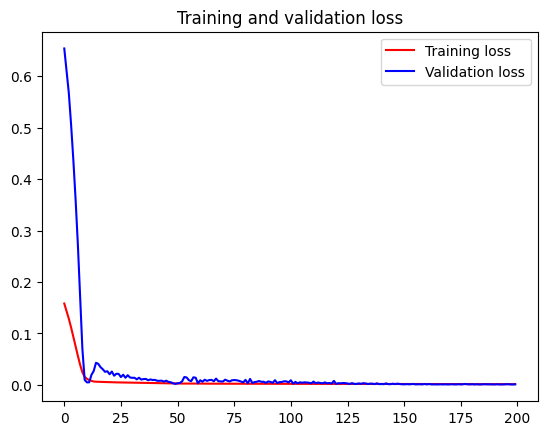

<Figure size 640x480 with 0 Axes>

Train data RMSE:  14.9827019702317
Train data MSE:  224.48135832878484
Train data MAE:  11.24124135812282
-------------------------------------------------------------------------------------
Test data RMSE:  13.553638172775619
Test data MSE:  183.7011077185204
Test data MAE:  11.181096860362075
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[1041.050049, 995.5499879999999, 1003.25, 1000.9500120000001, 996.25, 1012.2500000000001, 1019.0999759999999, 1018.4500120000001, 994.049988, 1004.7999879999999, 1008.0499880000001, 992.849976, 991.4000239999999, 980.349976, 964.299988, nan, 957.1159318475175, 947.7449992934297, 937.4444601651822, 926.6293138597059, 915.1998535337684, 902.6099947628117, 889.3732055003213]
      dates  predicted_values
0  24-10-23        957.115932
1  25-10-23        947.744999
2  26-10-23        937.444460
3  27-10-23        926.629314
4  28-10-23        915.199854
5  29-10-23        902.609995
6  30-10-23        889.373206


In [7]:
na="/content/drive/MyDrive/AXISBANK.NS (1).csv"
display(na)

Total number of days present in the dataset:  7000
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7000 non-null   object 
 1   Open       6993 non-null   float64
 2   High       6993 non-null   float64
 3   Low        6993 non-null   float64
 4   Close      6993 non-null   float64
 5   Adj Close  6993 non-null   float64
 6   Volume     6993 non-null   float64
dtypes: float64(6), object(1)
memory usage: 382.9+ KB
Null Values: 42
NA values: True
Null Values: 0
NA values: False
Starting Date 1996-01-01
Ending Date 2023-10-23
                 Open       Close
Date                             
January    294.538497  294.285704
February   300.900127  300.471753
March      299.724249  299.391861
April      298.556248  298.535353
May        304.819398  304.088325
June       303.086994  303.13

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 5s 70ms/step - loss: 0.1008 - val_loss: 0.3028
Epoch 2/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0734 - val_loss: 0.2254
Epoch 3/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0502 - val_loss: 0.1573
Epoch 4/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0324 - val_loss: 0.0994
Epoch 5/200
9/9 [==============================] - 0s 25ms/step - loss: 0.0188 - val_loss: 0.0546
Epoch 6/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0100 - val_loss: 0.0233
Epoch 7/200
9/9 [==============================] - 0s 24ms/step - loss: 0.0053 - val_loss: 0.0070
Epoch 8/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/200
9/9 [==============================] 

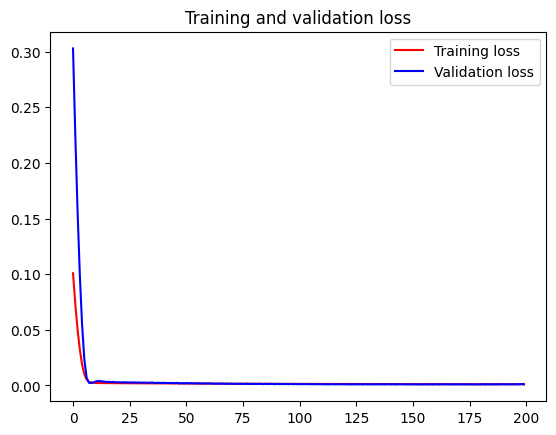

<Figure size 640x480 with 0 Axes>

Train data RMSE:  13.696056521025703
Train data MSE:  187.5819642271307
Train data MAE:  10.317238837706885
-------------------------------------------------------------------------------------
Test data RMSE:  13.244576069587021
Test data MSE:  175.4187952630772
Test data MAE:  10.209541890625005
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[1141.449951, 1123.800049, 1119.099976, 1127.300049, 1123.050049, 1126.5, 1128.75, 1130.400024, 1145.300049, 1135.300049, 1136.800049, 1153.400024, 1141.5, 1142.199951, 1122.449951, nan, 1138.969134445197, 1147.193172235026, 1158.6465245366994, 1172.8008792737057, 1189.3191035460582, 1207.887396848317, 1228.3269279919793]
      dates  predicted_values
0  24-10-23       1138.969134
1  25-10-23       1147.193172
2  26-10-23       1158.646525
3  27-10-23       1172.800879
4  28-10-23       1189.319104
5  29-10-23       1207.887397
6  30-10-23       1228.326928


In [8]:
na="/content/drive/MyDrive/SUNPHARMA.NS (1).csv"
display(na)

Total number of days present in the dataset:  5803
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5803 entries, 0 to 5802
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5803 non-null   object 
 1   Open       5796 non-null   float64
 2   High       5796 non-null   float64
 3   Low        5796 non-null   float64
 4   Close      5796 non-null   float64
 5   Adj Close  5796 non-null   float64
 6   Volume     5796 non-null   float64
dtypes: float64(6), object(1)
memory usage: 317.5+ KB
Null Values: 42
NA values: True
Null Values: 0
NA values: False
Starting Date 2000-08-02
Ending Date 2023-10-23
                 Open       Close
Date                             
January    235.793942  235.108395
February   236.231112  236.078491
March      226.331735  225.902647
April      224.646177  224.846888
May        240.553435  240.522866
June       249.569873  249.42

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 5s 98ms/step - loss: 0.1661 - val_loss: 0.7930
Epoch 2/200
9/9 [==============================] - 0s 37ms/step - loss: 0.1386 - val_loss: 0.6927
Epoch 3/200
9/9 [==============================] - 0s 44ms/step - loss: 0.1122 - val_loss: 0.5993
Epoch 4/200
9/9 [==============================] - 0s 45ms/step - loss: 0.0883 - val_loss: 0.5015
Epoch 5/200
9/9 [==============================] - 0s 38ms/step - loss: 0.0661 - val_loss: 0.4021
Epoch 6/200
9/9 [==============================] - 0s 34ms/step - loss: 0.0459 - val_loss: 0.2928
Epoch 7/200
9/9 [==============================] - 0s 42ms/step - loss: 0.0310 - val_loss: 0.1819
Epoch 8/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0241 - val_loss: 0.1113
Epoch 9/200
9/9 [==============================] 

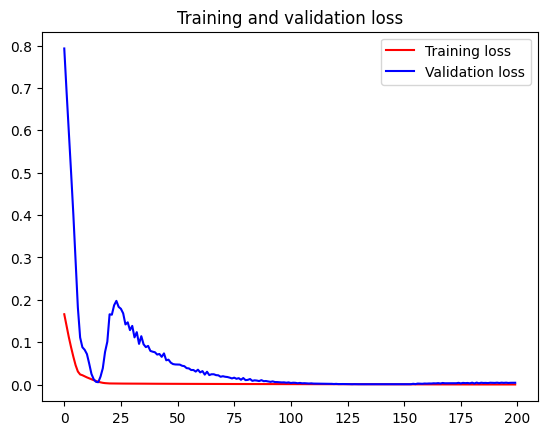

<Figure size 640x480 with 0 Axes>

Train data RMSE:  21.897671562545995
Train data MSE:  479.5080198611355
Train data MAE:  17.09437738647376
-------------------------------------------------------------------------------------
Test data RMSE:  72.21289025076281
Test data MSE:  5214.701518368715
Test data MAE:  60.20728227221942
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[1530.0, 1496.0500489999997, 1498.150024, 1501.25, 1522.5, 1528.099976, 1550.25, 1597.8499760000002, 1600.900024, 1601.699951, 1609.400024, 1600.599976, 1599.050049, 1596.449951, 1585.25, nan, 1461.206064622408, 1438.4073749881468, 1414.9847361143006, 1390.7171699992227, 1366.926234455965, 1344.6003798470622, 1324.058239081439]
      dates  predicted_values
0  24-10-23       1461.206065
1  25-10-23       1438.407375
2  26-10-23       1414.984736
3  27-10-23       1390.717170
4  28-10-23       1366.926234
5  29-10-23       1344.600380
6  30-10-23       1324.058239


In [9]:
na="/content/drive/MyDrive/TVSMOTOR.NS (1).csv"
display(na)

Total number of days present in the dataset:  6196
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6196 entries, 0 to 6195
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6196 non-null   object 
 1   Open       6196 non-null   float64
 2   High       6196 non-null   float64
 3   Low        6196 non-null   float64
 4   Close      6196 non-null   float64
 5   Adj Close  6196 non-null   float64
 6   Volume     6196 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 339.0+ KB
Null Values: 0
NA values: False
Null Values: 0
NA values: False
Starting Date 1999-03-11
Ending Date 2023-10-23
               Open     Close
Date                         
January    7.897140  7.895826
February   8.047941  8.053841
March      7.901415  7.899264
April      7.311335  7.302782
May        7.098281  7.095114
June       7.265323  7.272691
July       7.4203

Total data for prediction:  512


(512, 1)
train_data:  (307, 1)
test_data:  (205, 1)
X_train:  (291, 15)
y_train:  (291,)
X_test:  (189, 15)
y_test (189,)
X_train:  (291, 15, 1)
X_test:  (189, 15, 1)
Epoch 1/200
10/10 [==============================] - 3s 62ms/step - loss: 0.3815 - val_loss: 0.0356
Epoch 2/200
10/10 [==============================] - 0s 23ms/step - loss: 0.2888 - val_loss: 0.0204
Epoch 3/200
10/10 [==============================] - 0s 21ms/step - loss: 0.2082 - val_loss: 0.0107
Epoch 4/200
10/10 [==============================] - 0s 23ms/step - loss: 0.1381 - val_loss: 0.0063
Epoch 5/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0775 - val_loss: 0.0082
Epoch 6/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0339 - val_loss: 0.0165
Epoch 7/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0281
Epoch 8/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0114 - val_loss: 0.0288
Epoch 9/200
10/10 [==============

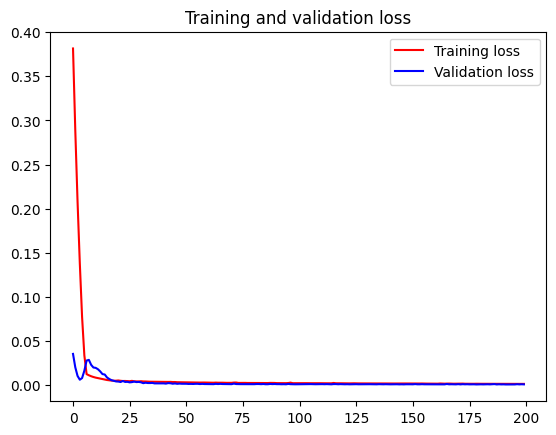

<Figure size 640x480 with 0 Axes>

Train data RMSE:  0.4591619171373892
Train data MSE:  0.21082966614928264
Train data MAE:  0.3582449635865516
-------------------------------------------------------------------------------------
Test data RMSE:  0.37156762906532914
Test data MSE:  0.13806250296923003
Test data MAE:  0.2558419575479499
Train predicted data:  (512, 1)
Test predicted data:  (512, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[17.0, 17.440001, 17.610001, 17.790001, 17.75, 17.85, 17.610001, 16.459999, 16.9, 17.209999, 17.35, 17.139999, 17.09, 16.969999, 16.780001, nan, 17.0577289051985, 17.09379011735219, 17.13389734932521, 17.17845525410618, 17.22540180167581, 17.274434182381704, 17.322934903467686]
      dates  predicted_values
0  24-10-23         17.057729
1  25-10-23         17.093790
2  26-10-23         17.133897
3  27-10-23         17.178455
4  28-10-23         17.225402
5  29-10-23         17.274434
6  30-10-23         17.322935


In [10]:
na="/content/drive/MyDrive/INFY (2).csv"
display(na)

Total number of days present in the dataset:  3928
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3928 non-null   object 
 1   Open       3921 non-null   float64
 2   High       3921 non-null   float64
 3   Low        3921 non-null   float64
 4   Close      3921 non-null   float64
 5   Adj Close  3921 non-null   float64
 6   Volume     3921 non-null   float64
dtypes: float64(6), object(1)
memory usage: 214.9+ KB
Null Values: 42
NA values: True
Null Values: 0
NA values: False
Starting Date 2007-11-27
Ending Date 2023-10-23
                 Open       Close
Date                             
January    315.453983  314.108643
February   299.138790  298.772197
March      308.819754  308.707323
April      320.163577  320.194702
May        325.495473  324.903668
June       330.384634  329.54

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 3s 62ms/step - loss: 0.5099 - val_loss: 0.3362
Epoch 2/200
9/9 [==============================] - 0s 20ms/step - loss: 0.4817 - val_loss: 0.3171
Epoch 3/200
9/9 [==============================] - 0s 20ms/step - loss: 0.4584 - val_loss: 0.3007
Epoch 4/200
9/9 [==============================] - 0s 19ms/step - loss: 0.4377 - val_loss: 0.2857
Epoch 5/200
9/9 [==============================] - 0s 19ms/step - loss: 0.4188 - val_loss: 0.2720
Epoch 6/200
9/9 [==============================] - 0s 21ms/step - loss: 0.4015 - val_loss: 0.2593
Epoch 7/200
9/9 [==============================] - 0s 21ms/step - loss: 0.3853 - val_loss: 0.2477
Epoch 8/200
9/9 [==============================] - 0s 19ms/step - loss: 0.3704 - val_loss: 0.2368
Epoch 9/200
9/9 [==============================] 

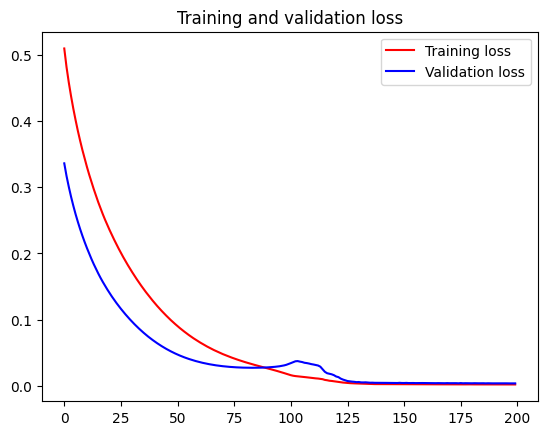

<Figure size 640x480 with 0 Axes>

Train data RMSE:  21.793248705806086
Train data MSE:  474.9456891531187
Train data MAE:  16.53954205905651
-------------------------------------------------------------------------------------
Test data RMSE:  30.186808220705778
Test data MSE:  911.24339055367
Test data MAE:  16.880382555485554
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[831.400024, 824.599976, 825.200012, 830.75, 790.049988, 819.5, 814.849976, 814.950012, 813.75, 805.650024, 805.099976, 798.599976, 792.849976, 793.650024, 771.450012, nan, 788.382188266803, 787.052185298927, 786.128005456837, 785.3723838626213, 785.0065134908657, 784.487369826376, 784.866012972526]
      dates  predicted_values
0  24-10-23        788.382188
1  25-10-23        787.052185
2  26-10-23        786.128005
3  27-10-23        785.372384
4  28-10-23        785.006513
5  29-10-23        784.487370
6  30-10-23        784.866013


In [11]:
na="/content/drive/MyDrive/ADANIPORTS.NS (1).csv"
display(na)

Total number of days present in the dataset:  7000
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7000 non-null   object 
 1   Open       6991 non-null   float64
 2   High       6991 non-null   float64
 3   Low        6991 non-null   float64
 4   Close      6991 non-null   float64
 5   Adj Close  6991 non-null   float64
 6   Volume     6991 non-null   float64
dtypes: float64(6), object(1)
memory usage: 382.9+ KB
Null Values: 54
NA values: True
Null Values: 0
NA values: False
Starting Date 1996-01-01
Ending Date 2023-10-23
                 Open       Close
Date                             
January    176.471488  175.953501
February   175.193807  174.549540
March      166.739637  166.384164
April      164.865762  164.902061
May        172.958446  172.794327
June       177.285105  177.04

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 4s 61ms/step - loss: 0.2388 - val_loss: 0.4902
Epoch 2/200
9/9 [==============================] - 0s 20ms/step - loss: 0.2229 - val_loss: 0.4618
Epoch 3/200
9/9 [==============================] - 0s 21ms/step - loss: 0.2072 - val_loss: 0.4336
Epoch 4/200
9/9 [==============================] - 0s 20ms/step - loss: 0.1890 - val_loss: 0.3985
Epoch 5/200
9/9 [==============================] - 0s 19ms/step - loss: 0.1614 - val_loss: 0.3327
Epoch 6/200
9/9 [==============================] - 0s 20ms/step - loss: 0.1284 - val_loss: 0.2539
Epoch 7/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0905 - val_loss: 0.1642
Epoch 8/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0578 - val_loss: 0.0695
Epoch 9/200
9/9 [==============================] 

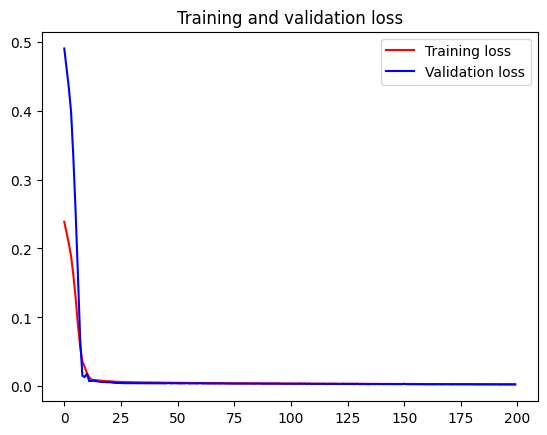

<Figure size 640x480 with 0 Axes>

Train data RMSE:  10.098683836040252
Train data MSE:  101.98341522030064
Train data MAE:  7.880225825525372
-------------------------------------------------------------------------------------
Test data RMSE:  9.76129079684052
Test data MSE:  95.28279802048343
Test data MAE:  7.3704722576129855
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[602.950012, 586.25, 592.150024, 594.25, 585.099976, 591.650024, 588.349976, 586.049988, 576.150024, 575.650024, 576.450012, 572.650024, 571.200012, 563.099976, 552.950012, nan, 553.7589226543364, 549.4737058532675, 544.8613230876674, 540.4903230249724, 536.3436468169206, 532.2769766072166, 528.3480850286408]
      dates  predicted_values
0  24-10-23        553.758923
1  25-10-23        549.473706
2  26-10-23        544.861323
3  27-10-23        540.490323
4  28-10-23        536.343647
5  29-10-23        532.276977
6  30-10-23        528.348085


In [12]:
na="/content/drive/MyDrive/SBIN.NS.csv"
display(na)

Total number of days present in the dataset:  5038
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5038 entries, 0 to 5037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5038 non-null   object 
 1   Open       5031 non-null   float64
 2   High       5031 non-null   float64
 3   Low        5031 non-null   float64
 4   Close      5031 non-null   float64
 5   Adj Close  5031 non-null   float64
 6   Volume     5031 non-null   float64
dtypes: float64(6), object(1)
memory usage: 275.6+ KB
Null Values: 42
NA values: True
Null Values: 0
NA values: False
Starting Date 2003-07-09
Ending Date 2023-10-23
                  Open        Close
Date                               
January    3690.978813  3684.495595
February   3587.355874  3577.615555
March      3401.504845  3393.429536
April      3426.213914  3427.405387
May        3518.251415  3519.504482
June       3626

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 3s 61ms/step - loss: 0.1850 - val_loss: 0.4943
Epoch 2/200
9/9 [==============================] - 0s 19ms/step - loss: 0.1584 - val_loss: 0.4384
Epoch 3/200
9/9 [==============================] - 0s 20ms/step - loss: 0.1341 - val_loss: 0.3868
Epoch 4/200
9/9 [==============================] - 0s 22ms/step - loss: 0.1120 - val_loss: 0.3364
Epoch 5/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0914 - val_loss: 0.2856
Epoch 6/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0728 - val_loss: 0.2348
Epoch 7/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0546 - val_loss: 0.1823
Epoch 8/200
9/9 [==============================] - 0s 20ms/step - loss: 0.0372 - val_loss: 0.1305
Epoch 9/200
9/9 [==============================] 

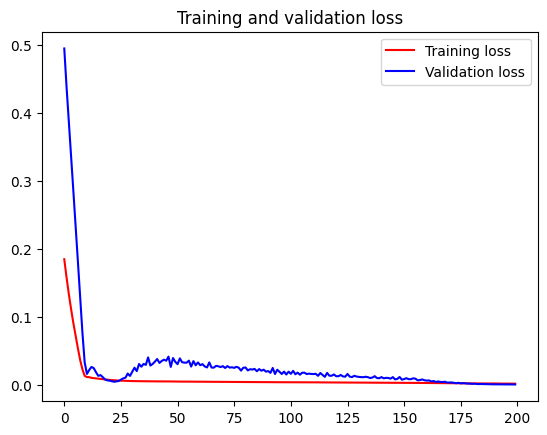

<Figure size 640x480 with 0 Axes>

Train data RMSE:  191.1067638493356
Train data MSE:  36521.79518896573
Train data MAE:  138.36083133558367
-------------------------------------------------------------------------------------
Test data RMSE:  131.86467529116112
Test data MSE:  17388.29258964336
Test data MAE:  103.35421396202956
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[10346.900391, 10129.849609, 10210.150391, 10302.049805, 10244.799805, 10375.0, 10412.099609, 10580.900391, 10727.549805, 10704.5, 10750.799805, 10788.450195, 10771.700195, 10725.650391, 10553.650391, nan, 10688.52013662354, 10638.614522018559, 10582.73031497414, 10528.242350636074, 10473.121429326458, 10410.555716990772, 10342.619932544083]
      dates  predicted_values
0  24-10-23      10688.520137
1  25-10-23      10638.614522
2  26-10-23      10582.730315
3  27-10-23      10528.242351
4  28-10-23      10473.121429
5  29-10-23      10410.555717
6  30-10-23      10342.619933


In [13]:
na="/content/drive/MyDrive/MARUTI.NS (1).csv"
display(na)

Total number of days present in the dataset:  5600
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5600 non-null   object 
 1   Open       5600 non-null   float64
 2   High       5600 non-null   float64
 3   Low        5600 non-null   float64
 4   Close      5600 non-null   float64
 5   Adj Close  5600 non-null   float64
 6   Volume     5600 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 306.4+ KB
Null Values: 0
NA values: False
Null Values: 0
NA values: False
Starting Date 2001-07-20
Ending Date 2023-10-23
                Open      Close
Date                           
January    26.478497  26.464133
February   26.635922  26.645542
March      26.217160  26.220349
April      25.901138  25.854061
May        26.179080  26.198972
June       27.041751  27.044407
J

Total data for prediction:  512


(512, 1)
train_data:  (307, 1)
test_data:  (205, 1)
X_train:  (291, 15)
y_train:  (291,)
X_test:  (189, 15)
y_test (189,)
X_train:  (291, 15, 1)
X_test:  (189, 15, 1)
Epoch 1/200
10/10 [==============================] - 5s 64ms/step - loss: 0.2593 - val_loss: 0.3224
Epoch 2/200
10/10 [==============================] - 0s 21ms/step - loss: 0.2171 - val_loss: 0.2711
Epoch 3/200
10/10 [==============================] - 0s 20ms/step - loss: 0.1811 - val_loss: 0.2273
Epoch 4/200
10/10 [==============================] - 0s 21ms/step - loss: 0.1516 - val_loss: 0.1916
Epoch 5/200
10/10 [==============================] - 0s 22ms/step - loss: 0.1261 - val_loss: 0.1585
Epoch 6/200
10/10 [==============================] - 0s 22ms/step - loss: 0.1022 - val_loss: 0.1256
Epoch 7/200
10/10 [==============================] - 0s 20ms/step - loss: 0.0793 - val_loss: 0.0950
Epoch 8/200
10/10 [==============================] - 0s 19ms/step - loss: 0.0589 - val_loss: 0.0671
Epoch 9/200
10/10 [==============

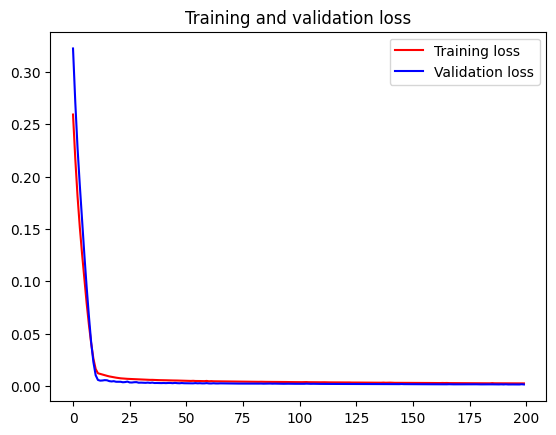

<Figure size 640x480 with 0 Axes>

Train data RMSE:  1.3937658500908157
Train data MSE:  1.9425832448793738
Train data MAE:  1.0739039587570134
-------------------------------------------------------------------------------------
Test data RMSE:  1.0660978780569625
Test data MSE:  1.136564685597558
Test data MAE:  0.7761466537530481
Train predicted data:  (512, 1)
Test predicted data:  (512, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[57.52, 59.259998, 59.279999, 59.290001000000004, 58.86999900000001, 59.02, 59.11999899999999, 58.799999, 58.200001, 59.009997999999996, 58.240002, 57.40000199999999, 57.25, 57.27, 56.650002, nan, 57.27811343737951, 57.423806104043784, 57.613672579208526, 57.8233549411093, 58.04535247541168, 58.27295532011807, 58.504968941479625]
      dates  predicted_values
0  24-10-23         57.278113
1  25-10-23         57.423806
2  26-10-23         57.613673
3  27-10-23         57.823355
4  28-10-23         58.045352
5  29-10-23         58.272955
6  30-10-23         58.504969


In [14]:
na="/content/drive/MyDrive/HDB (1).csv"
display(na)

Total number of days present in the dataset:  5305
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5305 entries, 0 to 5304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5305 non-null   object 
 1   Open       5295 non-null   float64
 2   High       5295 non-null   float64
 3   Low        5295 non-null   float64
 4   Close      5295 non-null   float64
 5   Adj Close  5295 non-null   float64
 6   Volume     5295 non-null   float64
dtypes: float64(6), object(1)
memory usage: 290.2+ KB
Null Values: 60
NA values: True
Null Values: 0
NA values: False
Starting Date 2002-07-01
Ending Date 2023-10-23
                 Open       Close
Date                             
January    534.296791  533.119607
February   533.943829  533.029160
March      535.633197  535.888480
April      534.737104  533.768436
May        545.883088  545.194458
June       546.074913  545.52

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 4s 97ms/step - loss: 0.0691 - val_loss: 0.5765
Epoch 2/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0519 - val_loss: 0.4729
Epoch 3/200
9/9 [==============================] - 0s 32ms/step - loss: 0.0377 - val_loss: 0.3794
Epoch 4/200
9/9 [==============================] - 0s 40ms/step - loss: 0.0271 - val_loss: 0.2952
Epoch 5/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0191 - val_loss: 0.2224
Epoch 6/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0137 - val_loss: 0.1620
Epoch 7/200
9/9 [==============================] - 0s 41ms/step - loss: 0.0108 - val_loss: 0.1140
Epoch 8/200
9/9 [==============================] - 0s 41ms/step - loss: 0.0095 - val_loss: 0.0792
Epoch 9/200
9/9 [==============================] 

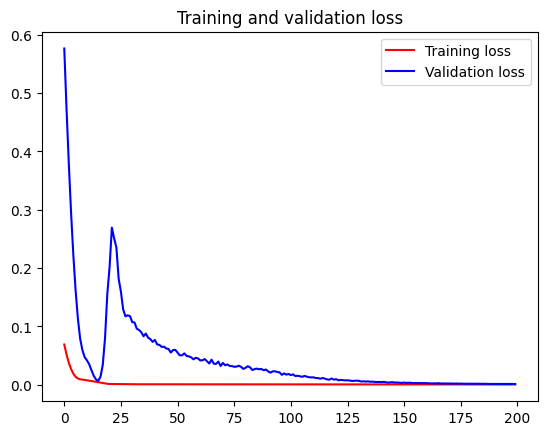

<Figure size 640x480 with 0 Axes>

Train data RMSE:  26.592063407304327
Train data MSE:  707.1378362580938
Train data MAE:  20.604804813915504
-------------------------------------------------------------------------------------
Test data RMSE:  40.94236500192566
Test data MSE:  1676.277251950907
Test data MAE:  30.188514635626678
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[1678.650024, 1695.449951, 1690.900024, 1704.449951, 1699.25, 1707.099976, 1751.5999760000002, 1730.0, 1715.150024, 1717.150024, 1713.099976, 1721.699951, 1706.550049, 1692.599976, 1698.949951, nan, 1710.6903502009948, 1711.9197077937713, 1712.5030250926843, 1713.090668115387, 1713.777016290018, 1714.5382125944648, 1715.3806145318727]
      dates  predicted_values
0  24-10-23       1710.690350
1  25-10-23       1711.919708
2  26-10-23       1712.503025
3  27-10-23       1713.090668
4  28-10-23       1713.777016
5  29-10-23       1714.538213
6  30-10-23       1715.380615


In [15]:
na="/content/drive/MyDrive/CUMMINSIND.NS (1).csv"
display(na)

Total number of days present in the dataset:  3230
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3230 non-null   object 
 1   Open       3224 non-null   float64
 2   High       3224 non-null   float64
 3   Low        3224 non-null   float64
 4   Close      3224 non-null   float64
 5   Adj Close  3224 non-null   float64
 6   Volume     3224 non-null   float64
dtypes: float64(6), object(1)
memory usage: 176.8+ KB
Null Values: 36
NA values: True
Null Values: 0
NA values: False
Starting Date 2010-09-29
Ending Date 2023-10-23
                 Open       Close
Date                             
January    497.116925  495.183578
February   498.259588  498.482650
March      531.139043  531.314925
April      541.818421  542.175800
May        551.419402  549.332168
June       564.777138  563.73

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 4s 64ms/step - loss: 0.0972 - val_loss: 0.0366
Epoch 2/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0699 - val_loss: 0.0237
Epoch 3/200
9/9 [==============================] - 0s 20ms/step - loss: 0.0453 - val_loss: 0.0132
Epoch 4/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0240 - val_loss: 0.0066
Epoch 5/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0115 - val_loss: 0.0053
Epoch 6/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 7/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0099 - val_loss: 0.0057
Epoch 8/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 9/200
9/9 [==============================] 

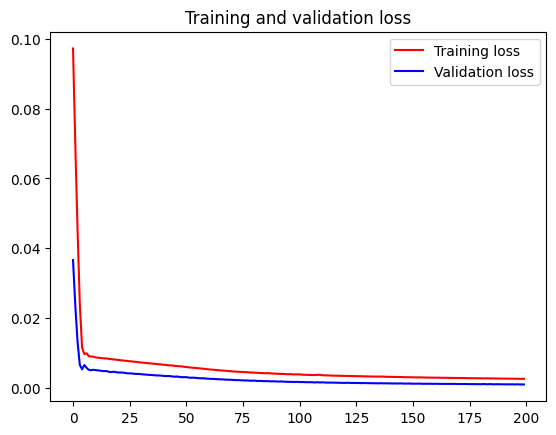

<Figure size 640x480 with 0 Axes>

Train data RMSE:  60.74390310615385
Train data MSE:  3689.8217645698073
Train data MAE:  45.330404351725825
-------------------------------------------------------------------------------------
Test data RMSE:  37.092681008231416
Test data MSE:  1375.8669843784114
Test data MAE:  27.204472343077967
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[2119.5, 2090.199951, 2103.800049, 2108.5, 2068.949951, 2065.5, 2093.699951, 2087.699951, 2083.350098, 2111.100098, 2125.399902, 2105.600098, 2092.649902, 2084.600098, 2019.1500240000003, nan, 2055.3256689918453, 2055.1416022306757, 2052.2453189337825, 2049.588861684499, 2047.3942250629466, 2045.3484236740583, 2043.5631917939504]
      dates  predicted_values
0  24-10-23       2055.325669
1  25-10-23       2055.141602
2  26-10-23       2052.245319
3  27-10-23       2049.588862
4  28-10-23       2047.394225
5  29-10-23       2045.348424
6  30-10-23       2043.563192


In [16]:
na="/content/drive/MyDrive/DEEPAKNTR.NS (1).csv"
display(na)

Total number of days present in the dataset:  1508
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1508 non-null   object 
 1   Open       1508 non-null   float64
 2   High       1508 non-null   float64
 3   Low        1508 non-null   float64
 4   Close      1508 non-null   float64
 5   Adj Close  1508 non-null   float64
 6   Volume     1508 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.6+ KB
Null Values: 0
NA values: False
Null Values: 0
NA values: False
Starting Date 2017-09-18
Ending Date 2023-10-23
                  Open        Close
Date                               
January    2194.696436  2172.373262
February   2153.352992  2157.171197
March      2239.725947  2228.224135
April      2144.551156  2150.827885
May        2122.198494  2119.885878
June  

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 3s 60ms/step - loss: 0.3578 - val_loss: 0.2366
Epoch 2/200
9/9 [==============================] - 0s 18ms/step - loss: 0.3001 - val_loss: 0.1984
Epoch 3/200
9/9 [==============================] - 0s 19ms/step - loss: 0.2463 - val_loss: 0.1625
Epoch 4/200
9/9 [==============================] - 0s 21ms/step - loss: 0.1968 - val_loss: 0.1281
Epoch 5/200
9/9 [==============================] - 0s 19ms/step - loss: 0.1470 - val_loss: 0.0961
Epoch 6/200
9/9 [==============================] - 0s 20ms/step - loss: 0.1001 - val_loss: 0.0666
Epoch 7/200
9/9 [==============================] - 0s 20ms/step - loss: 0.0590 - val_loss: 0.0406
Epoch 8/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0236 - val_loss: 0.0232
Epoch 9/200
9/9 [==============================] 

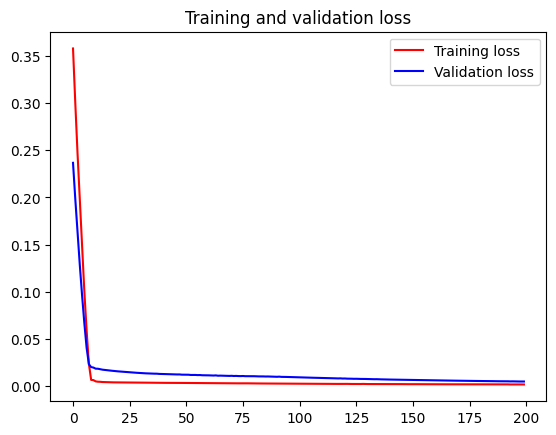

<Figure size 640x480 with 0 Axes>

Train data RMSE:  128.29142051669746
Train data MSE:  16458.6885781921
Train data MAE:  97.77309892214723
-------------------------------------------------------------------------------------
Test data RMSE:  216.8700676694979
Test data MSE:  47032.6262509726
Test data MAE:  175.51497529956316
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[5297.450195, 5216.450195, 5148.100098, 5128.75, 5104.649902, 5170.450195, 5254.700195, 5290.299805, 5339.950195, 5388.850098, 5474.350098, 5475.299805, 5501.799805, 5520.899902, 5418.0, nan, 5446.286838671307, 5448.647332829446, 5441.611625816839, 5430.073800206159, 5414.056836391189, 5393.266251745149, 5368.904995752257]
      dates  predicted_values
0  24-10-23       5446.286839
1  25-10-23       5448.647333
2  26-10-23       5441.611626
3  27-10-23       5430.073800
4  28-10-23       5414.056836
5  29-10-23       5393.266252
6  30-10-23       5368.904996


In [17]:
na="/content/drive/MyDrive/DIXON.NS (1).csv"
display(na)

Total number of days present in the dataset:  251
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB
Null Values: 0
NA values: False
Null Values: 0
NA values: False
Starting Date 2022-10-24
Ending Date 2023-10-23
                Open      Close
Date                           
January    50.587000  50.694500
February   50.581579  50.671053
March      50.256522  50.190000
April      53.932105  53.970000
May        53.546818  53.491818
June       50.941904  50.970953
July 

Total data for prediction:  251


(251, 1)
train_data:  (150, 1)
test_data:  (101, 1)
X_train:  (134, 15)
y_train:  (134,)
X_test:  (85, 15)
y_test (85,)
X_train:  (134, 15, 1)
X_test:  (85, 15, 1)
Epoch 1/200
5/5 [==============================] - 4s 112ms/step - loss: 0.6177 - val_loss: 0.5063
Epoch 2/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5865 - val_loss: 0.4794
Epoch 3/200
5/5 [==============================] - 0s 22ms/step - loss: 0.5574 - val_loss: 0.4540
Epoch 4/200
5/5 [==============================] - 0s 22ms/step - loss: 0.5299 - val_loss: 0.4300
Epoch 5/200
5/5 [==============================] - 0s 29ms/step - loss: 0.5033 - val_loss: 0.4072
Epoch 6/200
5/5 [==============================] - 0s 21ms/step - loss: 0.4784 - val_loss: 0.3852
Epoch 7/200
5/5 [==============================] - 0s 22ms/step - loss: 0.4547 - val_loss: 0.3640
Epoch 8/200
5/5 [==============================] - 0s 22ms/step - loss: 0.4314 - val_loss: 0.3435
Epoch 9/200
5/5 [==============================] - 

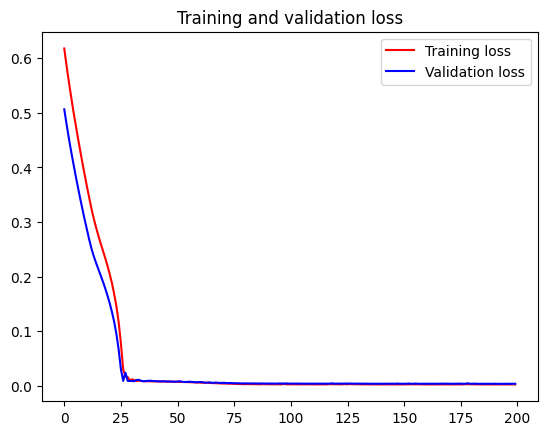

<Figure size 640x480 with 0 Axes>

Train data RMSE:  0.5589529078173977
Train data MSE:  0.31242835315752426
Train data MAE:  0.44816958767016984
-------------------------------------------------------------------------------------
Test data RMSE:  0.6821705158347862
Test data MSE:  0.4653566126742983
Test data MAE:  0.5476980683134189
Train predicted data:  (251, 1)
Test predicted data:  (251, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[48.79000099999999, 48.93, 48.939999, 48.220001, 48.019999999999996, 48.49999999999999, 48.339999999999996, 47.77, 47.79999899999999, 48.009998, 48.380001, 48.360001, 48.389999, 48.20000100000001, 48.560001, nan, 48.98890601111746, 49.16995489431715, 49.36384265853262, 49.52870884342289, 49.6942915369401, 49.866943296624186, 50.08942849619484]
      dates  predicted_values
0  24-10-23         48.988906
1  25-10-23         49.169955
2  26-10-23         49.363843
3  27-10-23         49.528709
4  28-10-23         49.694292
5  29-10-23         49.866943
6  30-10-23         50.089428


In [18]:
na="/content/drive/MyDrive/UL (1).csv"
display(na)

Total number of days present in the dataset:  5275
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5275 entries, 0 to 5274
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5275 non-null   object 
 1   Open       5266 non-null   float64
 2   High       5266 non-null   float64
 3   Low        5266 non-null   float64
 4   Close      5266 non-null   float64
 5   Adj Close  5266 non-null   float64
 6   Volume     5266 non-null   float64
dtypes: float64(6), object(1)
memory usage: 288.6+ KB
Null Values: 54
NA values: True
Null Values: 0
NA values: False
Starting Date 2002-08-12
Ending Date 2023-10-23
                  Open        Close
Date                               
January    1142.303053  1141.751217
February   1147.772760  1145.713017
March      1111.642947  1112.006191
April      1105.764695  1104.952525
May        1134.585448  1133.770022
June       1154

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 5s 116ms/step - loss: 0.2465 - val_loss: 0.1463
Epoch 2/200
9/9 [==============================] - 0s 44ms/step - loss: 0.2280 - val_loss: 0.1325
Epoch 3/200
9/9 [==============================] - 0s 40ms/step - loss: 0.2107 - val_loss: 0.1195
Epoch 4/200
9/9 [==============================] - 0s 47ms/step - loss: 0.1946 - val_loss: 0.1074
Epoch 5/200
9/9 [==============================] - 0s 45ms/step - loss: 0.1787 - val_loss: 0.0965
Epoch 6/200
9/9 [==============================] - 0s 39ms/step - loss: 0.1639 - val_loss: 0.0859
Epoch 7/200
9/9 [==============================] - 0s 41ms/step - loss: 0.1490 - val_loss: 0.0752
Epoch 8/200
9/9 [==============================] - 0s 37ms/step - loss: 0.1338 - val_loss: 0.0628
Epoch 9/200
9/9 [==============================]

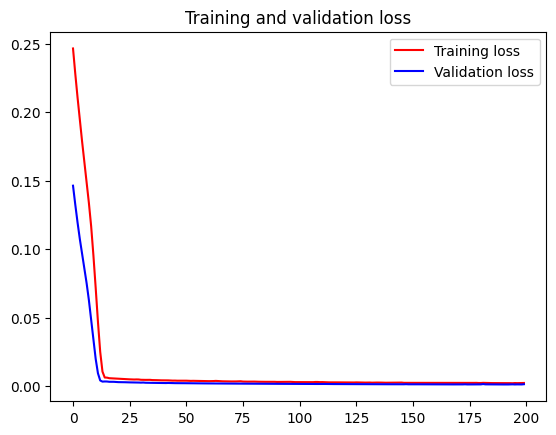

<Figure size 640x480 with 0 Axes>

Train data RMSE:  50.108515193726085
Train data MSE:  2510.863294919878
Train data MAE:  38.6167068615527
-------------------------------------------------------------------------------------
Test data RMSE:  39.18665363758759
Test data MSE:  1535.5938233122565
Test data MAE:  29.39954924386761
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[3513.850098, 3537.75, 3589.350098, 3621.399902, 3638.350098, 3628.899902, 3609.899902, 3542.550049, 3570.850098, 3524.050049, 3507.050049, 3487.2500000000005, 3455.649902, 3494.550049, 3410.149902, nan, 3406.223960336259, 3392.118947221574, 3379.8007246716024, 3367.855097870768, 3356.1794214036518, 3345.111488629217, 3334.5459960454073]
      dates  predicted_values
0  24-10-23       3406.223960
1  25-10-23       3392.118947
2  26-10-23       3379.800725
3  27-10-23       3367.855098
4  28-10-23       3356.179421
5  29-10-23       3345.111489
6  30-10-23       3334.545996


In [19]:
na="/content/drive/MyDrive/TCS.NS (1).csv"
display(na)

Total number of days present in the dataset:  5275
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5275 entries, 0 to 5274
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5275 non-null   object 
 1   Open       5269 non-null   float64
 2   High       5269 non-null   float64
 3   Low        5269 non-null   float64
 4   Close      5269 non-null   float64
 5   Adj Close  5269 non-null   float64
 6   Volume     5269 non-null   float64
dtypes: float64(6), object(1)
memory usage: 288.6+ KB
Null Values: 36
NA values: True
Null Values: 0
NA values: False
Starting Date 2002-08-12
Ending Date 2023-10-23
                 Open       Close
Date                             
January    346.136620  345.743819
February   350.834969  350.592788
March      344.786875  344.617277
April      335.698163  335.232366
May        336.175429  335.994098
June       342.299824  342.05

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 5s 121ms/step - loss: 0.2957 - val_loss: 0.4190
Epoch 2/200
9/9 [==============================] - 0s 51ms/step - loss: 0.2629 - val_loss: 0.3751
Epoch 3/200
9/9 [==============================] - 0s 36ms/step - loss: 0.2363 - val_loss: 0.3434
Epoch 4/200
9/9 [==============================] - 0s 38ms/step - loss: 0.2172 - val_loss: 0.3179
Epoch 5/200
9/9 [==============================] - 0s 39ms/step - loss: 0.2008 - val_loss: 0.2967
Epoch 6/200
9/9 [==============================] - 0s 32ms/step - loss: 0.1877 - val_loss: 0.2788
Epoch 7/200
9/9 [==============================] - 0s 39ms/step - loss: 0.1764 - val_loss: 0.2623
Epoch 8/200
9/9 [==============================] - 0s 41ms/step - loss: 0.1654 - val_loss: 0.2465
Epoch 9/200
9/9 [==============================]

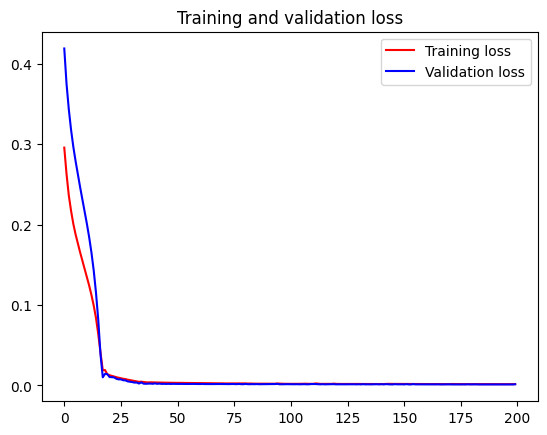

<Figure size 640x480 with 0 Axes>

Train data RMSE:  18.82359266243493
Train data MSE:  354.3276407212742
Train data MAE:  14.238564514958078
-------------------------------------------------------------------------------------
Test data RMSE:  17.617691712978335
Test data MSE:  310.38306129354555
Test data MAE:  13.870449939642139
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[1238.699951, 1239.550049, 1235.449951, 1237.699951, 1249.599976, 1261.800049, 1245.599976, 1223.75, 1255.900024, 1270.650024, 1277.150024, 1269.449951, 1267.349976, 1258.599976, 1236.650024, nan, 1224.814263704609, 1206.0989530118218, 1184.737881246399, 1160.032183948349, 1136.2380015881768, 1113.0073276193848, 1096.1923691662064]
      dates  predicted_values
0  24-10-23       1224.814264
1  25-10-23       1206.098953
2  26-10-23       1184.737881
3  27-10-23       1160.032184
4  28-10-23       1136.238002
5  29-10-23       1113.007328
6  30-10-23       1096.192369


In [20]:
na="/content/drive/MyDrive/HCLTECH.NS (1).csv"
display(na)

Total number of days present in the dataset:  1031
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1031 non-null   object 
 1   Open       1030 non-null   float64
 2   High       1030 non-null   float64
 3   Low        1030 non-null   float64
 4   Close      1030 non-null   float64
 5   Adj Close  1030 non-null   float64
 6   Volume     1030 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.5+ KB
Null Values: 6
NA values: True
Null Values: 0
NA values: False
Starting Date 2019-09-19
Ending Date 2023-10-20
                 Open       Close
Date                             
January     87.478526   87.251812
February    97.793724   98.182368
March       84.108110   83.690275
April       82.529247   82.065863
May         82.479530   82.759338
June        92.710814   93.1329

Total data for prediction:  511


(511, 1)
train_data:  (306, 1)
test_data:  (205, 1)
X_train:  (290, 15)
y_train:  (290,)
X_test:  (189, 15)
y_test (189,)
X_train:  (290, 15, 1)
X_test:  (189, 15, 1)
Epoch 1/200
10/10 [==============================] - 3s 59ms/step - loss: 0.2174 - val_loss: 0.0304
Epoch 2/200
10/10 [==============================] - 0s 23ms/step - loss: 0.1830 - val_loss: 0.0210
Epoch 3/200
10/10 [==============================] - 0s 20ms/step - loss: 0.1469 - val_loss: 0.0136
Epoch 4/200
10/10 [==============================] - 0s 21ms/step - loss: 0.1082 - val_loss: 0.0079
Epoch 5/200
10/10 [==============================] - 0s 22ms/step - loss: 0.0669 - val_loss: 0.0061
Epoch 6/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0310 - val_loss: 0.0126
Epoch 7/200
10/10 [==============================] - 0s 22ms/step - loss: 0.0141 - val_loss: 0.0194
Epoch 8/200
10/10 [==============================] - 0s 21ms/step - loss: 0.0142 - val_loss: 0.0120
Epoch 9/200
10/10 [==============

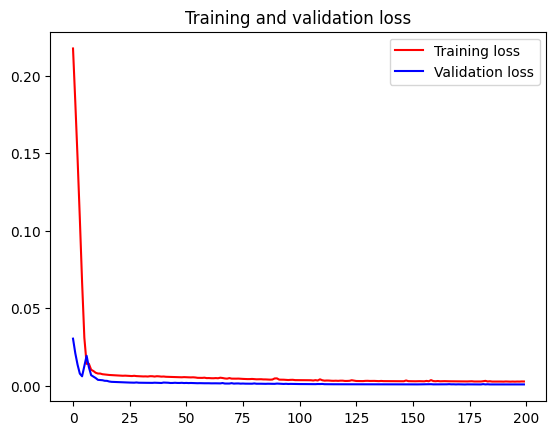

<Figure size 640x480 with 0 Axes>

Train data RMSE:  6.970146657969486
Train data MSE:  48.58294443360319
Train data MAE:  5.322826321484376
-------------------------------------------------------------------------------------
Test data RMSE:  3.9548745096688886
Test data MSE:  15.641032387228734
Test data MAE:  2.909695120370371
Train predicted data:  (511, 1)
Test predicted data:  (511, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[91.839996, 86.970001, 88.529999, 89.540001, 94.43, 90.730003, 91.629997, 89.440002, 87.980003, 88.059998, 90.519997, 90.410004, 88.290001, 87.75, 86.080002, nan, 87.22862760469246, 86.99557097221589, 86.66112968764362, 86.33627151082888, 86.02508980919845, 85.76878755750907, 85.49384971200816]
      dates  predicted_values
0  24-10-23         87.228628
1  25-10-23         86.995571
2  26-10-23         86.661130
3  27-10-23         86.336272
4  28-10-23         86.025090
5  29-10-23         85.768788
6  30-10-23         85.493850


In [21]:
na="/content/drive/MyDrive/DDOG (1).csv"
display(na)

Total number of days present in the dataset:  5305
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5305 entries, 0 to 5304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5305 non-null   object 
 1   Open       5295 non-null   float64
 2   High       5295 non-null   float64
 3   Low        5295 non-null   float64
 4   Close      5295 non-null   float64
 5   Adj Close  5295 non-null   float64
 6   Volume     5295 non-null   float64
dtypes: float64(6), object(1)
memory usage: 290.2+ KB
Null Values: 60
NA values: True
Null Values: 0
NA values: False
Starting Date 2002-07-01
Ending Date 2023-10-23
                 Open       Close
Date                             
January    279.534383  279.309305
February   277.084653  276.815268
March      263.082719  262.512536
April      261.338437  261.500566
May        272.149581  272.062973
June       274.163241  273.78

Total data for prediction:  505


(505, 1)
train_data:  (303, 1)
test_data:  (202, 1)
X_train:  (287, 15)
y_train:  (287,)
X_test:  (186, 15)
y_test (186,)
X_train:  (287, 15, 1)
X_test:  (186, 15, 1)
Epoch 1/200
9/9 [==============================] - 5s 79ms/step - loss: 0.0685 - val_loss: 0.1471
Epoch 2/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0415 - val_loss: 0.0824
Epoch 3/200
9/9 [==============================] - 0s 21ms/step - loss: 0.0210 - val_loss: 0.0339
Epoch 4/200
9/9 [==============================] - 0s 23ms/step - loss: 0.0092 - val_loss: 0.0064
Epoch 5/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 6/200
9/9 [==============================] - 0s 22ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 7/200
9/9 [==============================] - 0s 25ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 8/200
9/9 [==============================] - 0s 28ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 9/200
9/9 [==============================] 

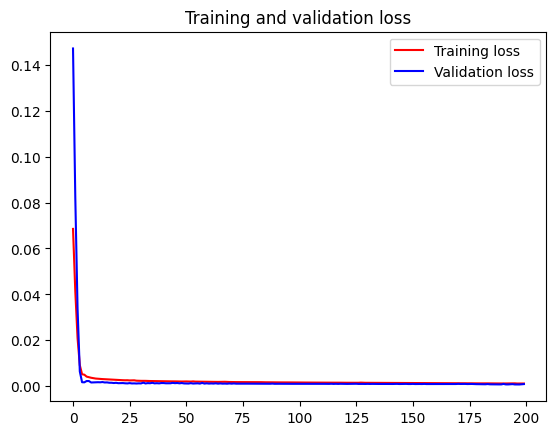

<Figure size 640x480 with 0 Axes>

Train data RMSE:  12.519519623415025
Train data MSE:  156.73837160107388
Train data MAE:  9.973662362981818
-------------------------------------------------------------------------------------
Test data RMSE:  10.652640460814203
Test data MSE:  113.47874878737582
Test data MAE:  8.329561936869965
Train predicted data:  (505, 1)
Test predicted data:  (505, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[940.299988, 930.0499880000001, 940.8499759999999, 945.2000119999999, 938.599976, 951.2000119999999, 953.099976, 954.2500000000001, 951.299988, 951.4000240000001, 953.900024, 943.75, 935.75, 932.75, 929.950012, nan, 923.135908466166, 917.3433865474325, 911.7604630017262, 906.4178608513919, 901.1991365558587, 896.1810155238695, 891.1471633186746]
      dates  predicted_values
0  24-10-23        923.135908
1  25-10-23        917.343387
2  26-10-23        911.760463
3  27-10-23        906.417861
4  28-10-23        901.199137
5  29-10-23        896.181016
6  30-10-23        891.147163


In [22]:
na="/content/drive/MyDrive/ICICIBANK.NS.csv"
display(na)

Total number of days present in the dataset:  6653
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6653 entries, 0 to 6652
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6653 non-null   object 
 1   Open       6653 non-null   float64
 2   High       6653 non-null   float64
 3   Low        6653 non-null   float64
 4   Close      6653 non-null   float64
 5   Adj Close  6653 non-null   float64
 6   Volume     6653 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 364.0+ KB
Null Values: 0
NA values: False
Null Values: 0
NA values: False
Starting Date 1997-05-15
Ending Date 2023-10-20
                Open      Close
Date                           
January    31.381246  31.396478
February   32.092686  32.091875
March      32.390623  32.408584
April      33.549253  33.524246
May        32.542984  32.555584
June       33.535464  33.550178
J

Total data for prediction:  511


(511, 1)
train_data:  (306, 1)
test_data:  (205, 1)
X_train:  (290, 15)
y_train:  (290,)
X_test:  (189, 15)
y_test (189,)
X_train:  (290, 15, 1)
X_test:  (189, 15, 1)
Epoch 1/200
10/10 [==============================] - 5s 108ms/step - loss: 0.3821 - val_loss: 0.1475
Epoch 2/200
10/10 [==============================] - 0s 44ms/step - loss: 0.3267 - val_loss: 0.1161
Epoch 3/200
10/10 [==============================] - 0s 42ms/step - loss: 0.2680 - val_loss: 0.0872
Epoch 4/200
10/10 [==============================] - 0s 33ms/step - loss: 0.2141 - val_loss: 0.0620
Epoch 5/200
10/10 [==============================] - 0s 33ms/step - loss: 0.1636 - val_loss: 0.0407
Epoch 6/200
10/10 [==============================] - 0s 39ms/step - loss: 0.1148 - val_loss: 0.0230
Epoch 7/200
10/10 [==============================] - 0s 31ms/step - loss: 0.0686 - val_loss: 0.0113
Epoch 8/200
10/10 [==============================] - 0s 37ms/step - loss: 0.0312 - val_loss: 0.0114
Epoch 9/200
10/10 [=============

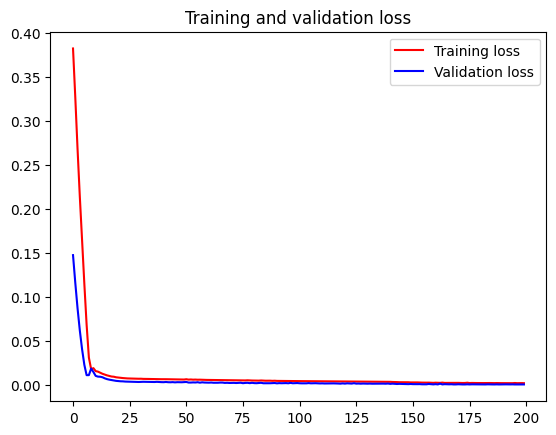

<Figure size 640x480 with 0 Axes>

Train data RMSE:  4.792245185797235
Train data MSE:  22.965613920796777
Train data MAE:  3.747760741305225
-------------------------------------------------------------------------------------
Test data RMSE:  2.8422680548069925
Test data MSE:  8.078487695376326
Test data MAE:  2.2188274284939244
Train predicted data:  (511, 1)
Test predicted data:  (511, 1)


Output of predicted next days:  7
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22]
[129.460007, 124.720001, 127.0, 125.95999900000001, 127.95999899999998, 128.259995, 129.479996, 131.830002, 132.330002, 129.789993, 132.550003, 131.470001, 128.130005, 128.399994, 125.169998, nan, 127.44433482678866, 127.18801623543507, 126.80881572154522, 126.453048033435, 126.10165078984475, 125.76548565029437, 125.44447895560653]
      dates  predicted_values
0  24-10-23        127.444335
1  25-10-23        127.188016
2  26-10-23        126.808816
3  27-10-23        126.453048
4  28-10-23        126.101651
5  29-10-23        125.765486
6  30-10-23        125.444479


In [23]:
na="/content/drive/MyDrive/AMZN.csv"
display(na)

In [1]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.14.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.14.0


In [2]:
pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1